In [2]:
from collections import defaultdict
import os
import gzip
import re
import numpy as np
import pandas as pd
import upsetplot as ups
import matplotlib.pyplot as plt
import matplotlib as mpl
from goatools.obo_parser import GODag
import Bio.UniProt.GOA as gafiterator
import pybiomart

# ignore warnings pandas for groubpy
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [3]:
# Rab name conversion to match the Rab names in Jean dataset. 
# Matched name according to this list: https://www.genenames.org/data/genegroup/#!/group/388
rab_conversion = {
                    'RAB1A': 'RAB1',
                    'RAB2A': 'RAB2',
                    'RAB7A': 'RAB7',
                    'RAB9A': 'RAB9',
                    'RAB11A': 'RAB11',
                    'RAB27A': 'RAB27',
                    'RAB4A': 'RAB4',
                    'RAB5A': 'RAB5',
                    'RAB5B': 'RAB5',
                    'RAB5C': 'RAB5',
                    'RAB6A': 'RAB6'
}

In [4]:
# Functions definition
def colname_to_mi(colname):
    " Convert column names to multiindex tuples "
    rab, rep = colname.split(' ')
    guanosine = re.match("[TD]", rep).group()
    num = rep[-1]
    return (rab, guanosine, num)


def get_orthologs(file):
    " Read the orthologs file from DIOPT and return a dictionary of orthologs "
    orthologs = pd.read_excel(file, header=1, 
                              usecols=['Search Term', 'Human Symbol', 'Weighted Score', 'Rank'],
                              index_col='Search Term')
    orthologs = orthologs[orthologs['Human Symbol'].notnull()] # Remove possible row with no human orthologs
    orthologs = orthologs[~orthologs.index.duplicated(keep='first')] # For duplicate gene names, keep best match
    return orthologs['Human Symbol'].to_dict()


def defaultdict_to_regular(d):
    " Convert multilayered defaultdict to regular dict"
    if isinstance(d, defaultdict):
        d = {k: defaultdict_to_regular(v) for k, v in d.items()}
    return d


def get_go_terms(go_dict, genes, set_of_interest='Jean'):
    " From a dictionary of GO terms, "
    go_terms = []
    for gene in genes:
        try:
            go_terms.extend(go_dict[gene])
        # No GO annotation, skip
        except KeyError:
            pass
    return list(np.unique(go_terms))

def get_annotation_stats(go_dict, genes):
    " Count the number of annotated and unannotated genes "
    annotated = np.intersect1d(genes, list(go_dict)).shape[0]
    unannotated = len(genes) - annotated
    return {'unannotated': unannotated, 'annotated': annotated}


def plot_upset(data, title=None, dataset_of_interest='This study', intersection_type='strict'):
    " Plot common interactors regardless of the capturing Rab "
    
    def total_intersections(data):
        " Prepare data to upset plot the total intersections between datasets "
        cat_serie = [pd.Series(True, index=list(elements), name=name)
                    for name, elements in data.items()]
        df = pd.concat(cat_serie, axis=1)
        df.where(df.notnull(), False, inplace=True)

        # Create
        mi = pd.MultiIndex.from_product([[True, False]]*len(data), names=genes_data.keys())
        mi = mi.drop([idx for idx in mi if sum(idx) == 0])
        data = pd.Series(index=mi, name='id')
        
        idx_names = np.array(data.index.names)
        for idx in data.index:
            usecols = [name for name in idx_names[list(idx)]]
            data[idx] = np.unique(df.index[df[usecols].all(axis=1)]).shape[0]
        
        # workaround to get the good value for the total size of each datasets
        totals_idx = [idx for idx in data.index if sum(idx) == 1]
        for idx in totals_idx:
            target_total = data[idx]
            related_subsets = [subset_idx for subset_idx in data.index
                            if np.array(subset_idx)[np.array(idx)].any()]
            bad_total = data[related_subsets].sum()
            corrected_total = target_total - (bad_total - target_total)
            data[idx] = corrected_total

        
        return data

    # Transform data according to the desired intersection type
    transform_data = {'strict': ups.from_contents, 'total': total_intersections}
    data = transform_data[intersection_type](data)
    
    
    upsetplot = ups.UpSet(data=data, show_counts=True,
                          sort_categories_by='input',
                          min_degree=1 if intersection_type == 'strict' else 2)
    upsetplot.style_categories([d for d in data if d != dataset_of_interest],
                            bar_facecolor='#5D5D5D', bar_edgecolor='#000000')
    upsetplot.style_categories(dataset_of_interest, bar_facecolor='#709B92', bar_edgecolor='#0E6655')
    upsetplot.style_subsets(absent=dataset_of_interest, facecolor='#5D5D5D', edgecolor='#000000')
    upsetplot.style_subsets(present=dataset_of_interest, facecolor='#709B92', edgecolor='#0E6655')
    fig = upsetplot.plot()

    # Rotate counts and adjust position
    for child in fig['intersections'].get_children():
        if isinstance(child, mpl.text.Text):
            x, y = child.get_position()
            new_y  = y + fig['intersections'].transAxes.transform((1, -0.9))[1]
            child.set(horizontalalignment='left', rotation=40, position=(x-0.2, new_y))
            
    if title:
        plt.suptitle(title, y=1.03)
    return fig


def plot_stacked_bar(stacked_data, category_name):
    " From a dictionary of go annotations stats, make a stacked bar plot "
    def split_text(text):
        " Split dataset name into two lines "
        return re.sub(r' (?=\()|(?<=\)) ', '\n', text)
        
    def get_xaxis_coord(fig):
        " Get axes coordinate to draw common xaxis "
        xdata = [fig.axes[0].get_position().get_points()[0][0],
        fig.axes[-1].get_position().get_points()[1][0]]
        ydata = [fig.axes[0].get_position().get_points()[0][1]]*2
        return xdata, ydata
    
    colors = {'face': {'unannotated': '#EC7063', 'annotated': '#709B92'},
            'edge': {'unannotated': '#C0392B', 'annotated': '#0E6655'}} 
    ncol = len(stacked_data)
       
    fig, axes = plt.subplots(1, ncol, sharey=True, )
    for col, (ds, data) in zip(range(ncol), stacked_data.items()):
        ax = axes[col]
        
        for frame_pos in ['bottom', 'top', 'right']:
            ax.spines[frame_pos].set_visible(False)
            
        if col != 0:
            ax.spines['left'].set_visible(False)
            ax.tick_params(left=False)
            
        ax.set_title(split_text(ds), y=-0.1, fontsize=9, rotation=45,
                     va='top', ha='center')
        bottom = np.zeros(3)
        for label, values in data.items():
            ax.bar(category_name.keys(), values, width=0.9, bottom=bottom, 
                   label=label, color=colors['face'][label],
                   edgecolor=colors['edge'][label])
            bottom += values
            
    ax.legend(loc='upper right')
    xdata, ydata = get_xaxis_coord(fig)
    fig.add_artist(mpl.lines.Line2D(xdata, ydata, color='black', linewidth=0.9))
    return fig


def non_filtered_proportion(scores, threshold):
    " Get the proportion of non filtered bait-interactor pairs "
    return scores[scores >= threshold].shape[0] / scores.shape[0] * 100

## Loading and cleaning datasets

In [5]:
## Files path

# Datasets
JEAN = 'data/SAINT Analysis 2-3 repeats-Organized.xlsx'
GILLINGHAM2019 = 'data/elife-45916-supp1-v2.xlsx'
GILLINGHAM2014 = 'data/mmc2.xlsx'
LI = 'data/mmc3.xlsx'
WILSON = 'data/wilson.tsv'

# Orthologs lists
GILLINGHAM2014_INT_ORTHOLOGS = 'data/orthologs/gillingham2014_interactors_orthologs.xlsx'
GILLINGHAM2014_BAIT_ORTHOLOGS = 'data/orthologs/gillingham2014_baits_orthologs.xlsx'
LI_INT_ORTHOLOGS = 'data/orthologs/li2016_interactors_orthologs.xlsx'
LI_BAIT_ORTHOLOGS = 'data/orthologs/li2016_baits_orthologs.xlsx'

# Figures output
INTERACTORS_COMPARISON = lambda type_: f'figures/genes_comparison_{type_}.svg'  # type_ = 'strict' or 'total' (intersection type)
GO_TERMS_COMPARISON = lambda cat: f'figures/GOterms_{cat}.svg' # cat = 'cellular_component', 'biological_process' or 'molecular_function'
RANDOM_INTERACTORS = lambda type_: f'figures/random_genes_comparison_{type_}.svg'
GO_TERMS_RANDOM_COMPARISON = lambda cat: f'figures/random_GOterms_{cat}.svg'
GO_ANNOTATED_GENES = 'figures/GO-annotated_genes.svg'

# GO terms
OBO = 'data/GOA/go-basic.obo'
GAF = lambda species: f'data/GOA/goa_{species}.gaf.gz' # species = 'human', 'mouse', 'fly'

In [6]:
## Jean et al.

saint_threshold = 0.95

jean_raw = pd.read_excel(JEAN, sheet_name='SAINT Analysis 2-3 repeats', usecols=['Bait', 'Prey', 'AvgSpec', 'SaintScore'])
jean_raw['Bait'] = jean_raw['Bait'].str.replace('R', 'RAB') # Change name to match other datasets
jean = jean_raw[jean_raw['SaintScore'] > saint_threshold] # Filter out low confidence interactions
jean = jean.pivot_table(index='Prey', columns='Bait', values='AvgSpec')
jean.index = jean.index.str.upper()
jean.fillna(0, inplace=True)

In [7]:
## Gillingham et al. (2019)

wd_threshold = 10

gill2019 = pd.read_excel(GILLINGHAM2019, skiprows=range(1,8), header=1, sheet_name='Spectral counts')
gill2019.index = gill2019['Gene Name'].str.upper()

# Filter out non-rab columns and convert colnames to multiindex
gill2019 = gill2019[[col for col in gill2019.columns if re.match(r'Rab\d+', col)]]
new_colnames = [colname_to_mi(col) for col in gill2019.columns]
gill2019.columns = pd.MultiIndex.from_tuples(new_colnames)
gill2019 = gill2019.groupby(level=[0,1], axis=1).sum()

# Get WD scores to filter out low confidence interactions
gill2019_wd_scores = pd.read_excel(GILLINGHAM2019, skiprows=range(1,8), header=1, sheet_name='Mean WD Score')
gill2019_wd_scores.index = gill2019_wd_scores['Gene Name'].str.upper()
gill2019_wd_scores = gill2019_wd_scores[[col for col in gill2019_wd_scores.columns if re.match(r'Rab\d+', col)]]
new_colnames = [tuple(colname.split('  ')) for colname in gill2019_wd_scores.columns]
gill2019_wd_scores.columns = pd.MultiIndex.from_tuples(new_colnames)

# If WD < threshold, set spectral counts to 0
gill2019 = gill2019.where(gill2019_wd_scores > wd_threshold, other=0)
gill2019 = gill2019[gill2019.sum(axis=1) > 0] # Remove rows with no spectral counts

# Sum GTP-locked and GDP-locked forms
gill2019 = gill2019.groupby(level=0, axis=1).sum()
gill2019.columns = gill2019.columns.str.upper()

In [8]:
## Gillingham et al. (2014)

threshold = 5

gill2014 = pd.read_excel(GILLINGHAM2014, skiprows=range(1, 8), header=1,
                         sheet_name='S1A - Total Spectral Counts')
# gill2014.index = gill2014['FBgn']
gill2014.index = gill2014['Symbol']

# Filter baits other than Rabs
usecols = [col for col in gill2014.columns if re.match(r'Rab\d+', col)]
gill2014 = gill2014[usecols]

# Load score to filter out low confidence interactors
gill2014_scores = pd.read_excel(GILLINGHAM2014, skiprows=range(1, 8), header=1,
                                sheet_name='S1B - S scores')
gill2014_scores.index = gill2014_scores['Symbol']
usecols = [col for col in gill2014_scores.columns if re.match(r'Rab\d+', col)]
gill2014_scores = gill2014_scores[usecols]
gill2014_scores.columns = gill2014_scores.columns.str.upper()


# Chang bait names for their human orthologs names and format it to match Jean's dataset
gill_baits_orthologs = get_orthologs(GILLINGHAM2014_BAIT_ORTHOLOGS)
gill2014.columns = gill2014.columns.map(gill_baits_orthologs)
gill2014.columns = [
    rab_conversion[rab] if rab in rab_conversion else rab for rab in gill2014.columns
]

# Filter out low confidence interactors
gill2014 = gill2014.where(gill2014_scores > threshold, other=0)
gill2014 = gill2014[gill2014.sum(axis=1) > 0] # Remove rows with no spectral counts


In [9]:
## Li et al. (2016)
li = pd.read_excel(LI, skiprows=1, header=0, sheet_name='Bait-prey information')
li = li.pivot_table(index=['Official Symbol'], columns=['Bait'], values='Average Spectal Counts')

# Change mouse rab names for their human orthologs names and format it to match Jean's dataset
li_bait_orthologs = get_orthologs(LI_BAIT_ORTHOLOGS)
li.columns = li.columns.map(li_bait_orthologs)
li.columns = [
    rab_conversion[rab] if rab in rab_conversion else rab for rab in li.columns
    ]
li.fillna(0, inplace=True)

## Comparing our study with Gillingham et al. (2014 and 2019) and Li et al.

In [37]:
# Get Rab which are common to all datasets
common = list(set.intersection(
    *map(set, [jean.columns, gill2019.columns, gill2014.columns, li.columns])
))

# Clean datasets from RAB not common to all datasets
filter_df = lambda df, common: df[df[common].sum(axis=1) != 0]

jean = filter_df(jean, common)
gill2019 = filter_df(gill2019, common)
gill2014 = filter_df(gill2014, common)
li = filter_df(li, common)

common

['RAB2', 'RAB7', 'RAB5', 'RAB6', 'RAB10', 'RAB9', 'RAB11', 'RAB30', 'RAB18']

### Interactors across studies

In [22]:
# Convert Li and Gillingham 2014 gene names to their human orthologs

## Gillingham et al. (2014)
gill_int_orthologs = get_orthologs(GILLINGHAM2014_INT_ORTHOLOGS)
gill2014_orthologs = gill2014[gill2014.index.isin(gill_int_orthologs)]  # Remove genes with no human orthologs
gill2014_orthologs.index = gill2014_orthologs.index.map(gill_int_orthologs).str.upper()   # Change gene names to human orthologs

## Li et al. (2016)
li_int_orthologs = get_orthologs(LI_INT_ORTHOLOGS)
li_orthologs = li[li.index.isin(li_int_orthologs)]  # Remove genes with no human orthologs
li_orthologs.index = li_orthologs.index.map(li_int_orthologs).str.upper()  # Change gene names to human orthologs

print(f'{len(gill2014) - len(gill2014_orthologs)} rows on {len(gill2014)} removed from Gillingham 2014 dataset due to lack of human orthologs')
print(f'{len(li) - len(li_orthologs)} row on {len(li)} removed from Li dataset due to lack of human orthologs')

2 rows on 489 removed from Gillingham 2014 dataset due to lack of human orthologs
2 row on 651 removed from Li dataset due to lack of human orthologs


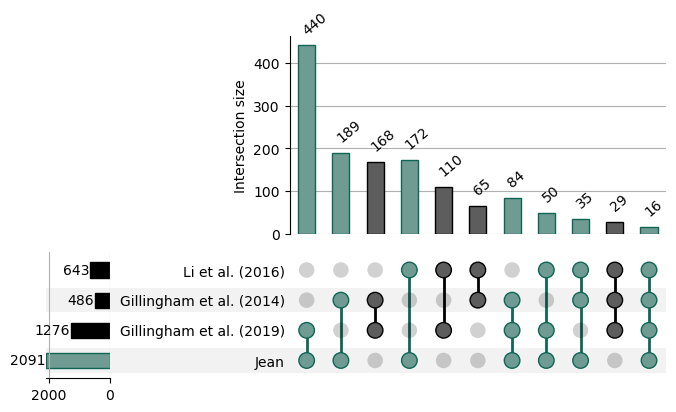

In [23]:
# Create dict of datasets for simpler data handling
genes_datasets = {'This study': jean,
                  'Gillingham et al. (2019)': gill2019,
                  'Gillingham et al. (2014)': gill2014_orthologs,
                  'Li et al. (2016)': li_orthologs}

# Plot upset of common interactors
genes_data = {dataset: list(np.unique(df.index.tolist())) for dataset, df in genes_datasets.items()}

fig = plot_upset(genes_data, intersection_type='total')
plt.savefig(INTERACTORS_COMPARISON('total'), bbox_inches='tight')

### GO analysis

In [24]:
# If GO terms and GO annotations are not downloaded, download them
if len(os.listdir('data/GOA')) == 0:
    from download_GO import download
    download()

In [25]:
# Get all interactors to extract GO terms from annotations
interactors = {'human': list(jean.index.tolist() + \
                             gill2019.index.tolist() + \
                             gill2014_orthologs.index.tolist()),
               'mouse': li.index.tolist(),
               'fly': gill2014.index.tolist()}

In [26]:
# Dict to store Go id for each interactors for each GO term category
goa = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

# Get GO annotations for the identified interactors
for species, interacts in interactors.items():
    with gzip.open(GAF(species), 'rt') as f:
        for annotation in gafiterator.gafiterator(f):
            if annotation['DB_Object_Symbol'] not in interacts:
                continue
            
            aspect = annotation['Aspect']
            symbol = annotation['DB_Object_Symbol']
            if annotation['GO_ID'] not in goa[species][aspect][symbol]:
                goa[species][aspect][symbol].append(annotation['GO_ID'])
                
goa = defaultdict_to_regular(goa)

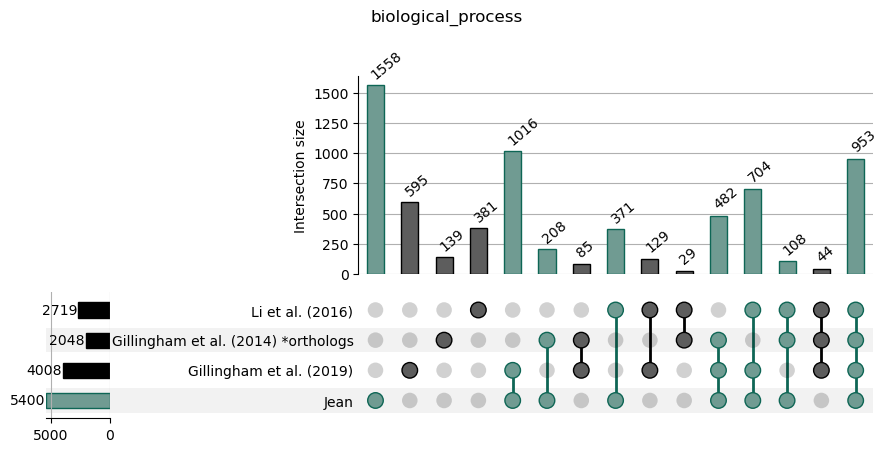

In [27]:
# Extract GO terms for each dataset and each GO terms category and make an upset plot
go_categories = {
        # 'F': 'molecular_function',
        # 'C': 'cellular_component',
        'P': 'biological_process'
        }

for category in go_categories:
    go_data = {
            'Jean': get_go_terms(goa['human'][category], jean.index),
            'Gillingham et al. (2019)': get_go_terms(goa['human'][category], gill2019.index),
            'Gillingham et al. (2014) *orthologs': get_go_terms(goa['human'][category], gill2014_orthologs.index),
            'Li et al. (2016)': get_go_terms(goa['mouse'][category], li.index),
            }
    
    fig = plot_upset(go_data, title=go_categories[category])
    plt.savefig(GO_TERMS_COMPARISON(go_categories[category]), bbox_inches='tight')

# Comparing our study with Wilson et al., 2023

In [9]:
## Jean et al.

saint_threshold = 0.95

jean_raw = pd.read_excel(JEAN, sheet_name='SAINT Analysis 2-3 repeats', usecols=['Bait', 'Prey', 'AvgSpec', 'SaintScore'])
jean_raw['Bait'] = jean_raw['Bait'].str.replace('R', 'RAB') # Change name to match other datasets
jean = jean_raw[jean_raw['SaintScore'] > saint_threshold] # Filter out low confidence interactions
jean = jean.pivot_table(index='Prey', columns='Bait', values='AvgSpec')
jean.index = jean.index.str.upper()
jean.fillna(0, inplace=True)

In [57]:
## Wilson et al. (2023)
saint_threshold = 0.95

wilson_raw = pd.read_csv(WILSON, sep='\t')
wilson = wilson_raw[wilson_raw['SaintScore'] > saint_threshold] # Filter out low confidence interactions
wilson = wilson.pivot_table(index='Prey', columns='Bait', values='AvgSpec')
wilson.index = wilson.index.str.upper()
wilson.columns = [
    rab_conversion[rab] if rab in rab_conversion else rab for rab in wilson.columns
]
wilson.fillna(0, inplace=True)

# Extract gene ids and gene names for gaf file to convert Wilson identification
columns = [
    'db', 'id', 'symbol', 'qualifier', 'go_id', 'db_reference', 'evidence_code',
    'with_from', 'aspect', 'db_object_name', 'db_object_synonym', 'db_object_type',
    'taxon', 'date', 'assigned_by' 'annotation_extension', 'gene_product_form_id'
]
gaf = pd.read_csv(GAF('human'), sep='\t', comment='!', index_col=False, names=columns)
name_mapper = dict(zip(gaf['id'], gaf['symbol']))

wilson.index = wilson.index.map(name_mapper).str.upper()

### Interactors across studies

In [58]:
# Get Rab which are common to all datasets
common = list(set.intersection(
    *map(set, [jean.columns, wilson.columns])
))

jean = jean[jean[common].sum(axis=1) != 0][common]
wilson = wilson[wilson[common].sum(axis=1) != 0][common]

common

['RAB4', 'RAB11', 'RAB25']

In [59]:
for dataset, genes in genes_data.items():
    print(f'{dataset}: {len(genes)} genes')

This study: 1890 genes
Wilson et al. (2023): 142 genes


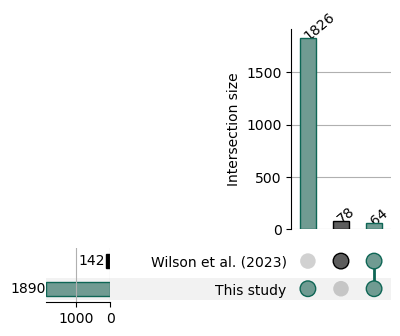

In [67]:
# Create dict of datasets for simpler data handling
genes_datasets = {
    'This study': jean,
    'Wilson et al. (2023)': wilson
}

# Plot upset of common interactors
genes_data = {
    dataset: list(np.unique(df.index.tolist())) for dataset, df in genes_datasets.items()
}

fig = plot_upset(genes_data, intersection_type='strict')
plt.savefig(INTERACTORS_COMPARISON('total'), bbox_inches='tight')

### GO analysis

In [62]:
# Get all interactors to extract GO terms from annotations
interactors = {
    'human': list(jean.index.tolist() + wilson.index.tolist()),
}

In [63]:
# Dict to store Go id for each interactors for each GO term category
goa = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

# Get GO annotations for the identified interactors
for species, interacts in interactors.items():
    with gzip.open(GAF(species), 'rt') as f:
        for annotation in gafiterator.gafiterator(f):
            if annotation['DB_Object_Symbol'] not in interacts:
                continue
            
            aspect = annotation['Aspect']
            symbol = annotation['DB_Object_Symbol']
            if annotation['GO_ID'] not in goa[species][aspect][symbol]:
                goa[species][aspect][symbol].append(annotation['GO_ID'])
                
goa = defaultdict_to_regular(goa)

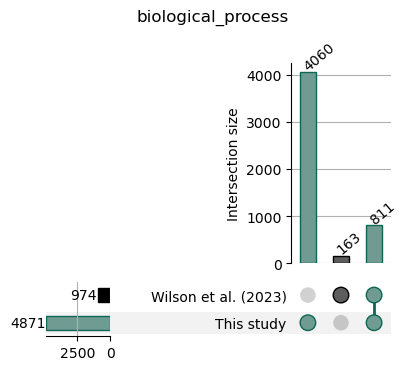

In [65]:
# Extract GO terms for each dataset and each GO terms category and make an upset plot
go_categories = {
        # 'F': 'molecular_function',
        # 'C': 'cellular_component',
        'P': 'biological_process'
        }

for category in go_categories:
    go_data = {
        'This study': get_go_terms(goa['human'][category], jean.index),
        'Wilson et al. (2023)': get_go_terms(goa['human'][category], wilson.index),
            }
    
    fig = plot_upset(go_data, title=go_categories[category])
    plt.savefig(GO_TERMS_COMPARISON(go_categories[category]), bbox_inches='tight')